In [1]:
from jax import config
#config.update("jax_enable_x64", True)
config.update('jax_num_cpu_devices', 8)

In [2]:
#NBVAL_SKIP
import os

# Tell XLA to fake 2 host CPU devices
#os.environ['XLA_FLAGS'] = '--xla_force_host_platform_device_count=3'

# Only make GPU 0 and GPU 1 visible to JAX:
#os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2,3,4,5'

#os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]   = "false"

import jax

# Now JAX will list two CpuDevice entries
print(jax.devices())
# → [CpuDevice(id=0), CpuDevice(id=1)]

[CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3), CpuDevice(id=4), CpuDevice(id=5), CpuDevice(id=6), CpuDevice(id=7)]


In [3]:
# NBVAL_SKIP
#import os
#  os.environ['SPS_HOME'] = '/mnt/storage/annalena_data/sps_fsps'
#os.environ['SPS_HOME'] = '/home/annalena/sps_fsps'
#os.environ['SPS_HOME'] = '/Users/annalena/Documents/GitHub/fsps'
#os.environ['SPS_HOME'] = '/export/home/aschaibl/fsps'
os.environ['SPS_HOME'] = '/home/annalena_data/sps_fsps'

## Step 1: Config

In [4]:
#NBVAL_SKIP
import matplotlib.pyplot as plt
from rubix.core.pipeline import RubixPipeline 
import os

galaxy_id = "g8.13e11"

config_NIHAO = {
    "pipeline":{"name": "calc_ifu_memory"},
    
    "logger": {
        "log_level": "DEBUG",
        "log_file_path": None,
        "format": "%(asctime)s - %(name)s - %(levelname)s - %(message)s",
    },
    "data": {
        "name": "NihaoHandler",
        "args": {
            "particle_type": ["stars"],
            "save_data_path": "data",
            "snapshot": "1024",
        },
        "load_galaxy_args": {"reuse": True, "id": galaxy_id},
        "subset": {"use_subset": False, "subset_size": 200000},
    },
    "simulation": {
        "name": "NIHAO",
        "args": {
            "path": f'/home/_data/nihao/nihao_classic/{galaxy_id}/{galaxy_id}.01024',
            "halo_path": f'/home/_data/nihao/nihao_classic/{galaxy_id}/{galaxy_id}.01024.z0.000.AHF_halos',
            "halo_id": 0,
        },
    },
    "output_path": "output",

    "telescope":
        {"name": "MUSE_WFM",
         "psf": {"name": "gaussian", "size": 5, "sigma": 0.6},
         "lsf": {"sigma": 0.5},
         "noise": {"signal_to_noise": 100,"noise_distribution": "normal"},},
    "cosmology":
        {"name": "PLANCK15"},
        
    "galaxy":
        {"dist_z": 0.01,
         "rotation": {"type": "matrix"}, #{"alpha": 0.0, "beta": 0.0, "gamma":0.0},
         "component": ["ThinDisk"], #None,
         "component_file": "./data/gsf/g8.26e11.01024.gmm_full_white_jzjcejpjc_5clusters_2018tags.dat",
        },
        
    "ssp": {
        "template": {
            "name": "FSPS" #"BruzualCharlot2003" #"Mastar_CB19_SLOG_1_5"
        },
        "dust": {
                "extinction_model": "Cardelli89",
                "dust_to_gas_ratio": 0.01,
                "dust_to_metals_ratio": 0.4,
                "dust_grain_density": 3.5,
                "Rv": 3.1,
            },
    },        
}

2025-06-12 11:44:53,495 - rubix - INFO - 
   ___  __  _____  _____  __
  / _ \/ / / / _ )/  _/ |/_/
 / , _/ /_/ / _  |/ /_>  <
/_/|_|\____/____/___/_/|_|


2025-06-12 11:44:53,497 - rubix - INFO - Rubix version: 0.0.post463+gb939c67.d20250612
2025-06-12 11:44:53,497 - rubix - INFO - JAX version: 0.6.0
2025-06-12 11:44:53,498 - rubix - INFO - Running on [CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3), CpuDevice(id=4), CpuDevice(id=5), CpuDevice(id=6), CpuDevice(id=7)] devices


## Step 2: Pipeline yaml

## Step 3: Run the pipeline

After defining the `config` and the `pipeline_config` you can simply run the whole pipeline by these two lines of code.

In [5]:
#NBVAL_SKIP
pipe = RubixPipeline(config_NIHAO)

/home/annalena/.conda/envs/rubix/lib/python3.12/site-packages/rubix/telescope/factory.py:26: UserWarning: No telescope config provided, using default stored in /home/annalena/.conda/envs/rubix/lib/python3.12/site-packages/rubix/telescope/telescopes.yaml
  warnings.warn(


In [6]:
#NBVAL_SKIP

inputdata = pipe.prepare_data()
rubixdata = pipe.run_sharded(inputdata)

2025-06-12 11:44:54,154 - rubix - INFO - Getting rubix data...
2025-06-12 11:44:54,155 - rubix - INFO - Loading data into input handler
2025-06-12 11:44:54,156 - rubix - INFO - Using PynbodyHandler to load a NIHAO galaxy
2025-06-12 11:44:54,159 - rubix - INFO - Galaxy redshift (dist_z) set to: 0.01
2025-06-12 11:44:54,174 - rubix - INFO - Simulation snapshot loaded from halo 0
2025-06-12 11:44:54,269 - rubix - INFO - Halo data loaded.
2025-06-12 11:44:58,599 - rubix - INFO - Rotation matrix calculated and saved to '/notebooks/data/rotation_matrix.npy'.
2025-06-12 11:44:58,601 - rubix - INFO - Loaded halo data for halo ID 0 with 1043618 particles.
2025-06-12 11:44:58,602 - rubix - INFO - Loading components from file: ./data/gsf/g8.26e11.01024.gmm_full_white_jzjcejpjc_5clusters_2018tags.dat.
2025-06-12 11:44:58,602 - rubix - INFO - Filtering components by: ['ThinDisk'].
2025-06-12 11:44:58,605 - rubix - INFO - Filtering components by tags: ['ThinDisk'].
2025-06-12 11:44:58,645 - rubix - 

Converted to Rubix format!


2025-06-12 11:45:00,001 - rubix - INFO - Data loaded with 153731 star particles and 0 gas particles.
2025-06-12 11:45:00,004 - rubix - INFO - Setting up the pipeline...
2025-06-12 11:45:00,005 - rubix - DEBUG - Pipeline Configuration: {'Transformers': {'rotate_galaxy': {'name': 'rotate_galaxy', 'depends_on': None, 'args': [], 'kwargs': {}}, 'filter_particles': {'name': 'filter_particles', 'depends_on': 'rotate_galaxy', 'args': [], 'kwargs': {}}, 'spaxel_assignment': {'name': 'spaxel_assignment', 'depends_on': 'filter_particles', 'args': [], 'kwargs': {}}, 'calculate_datacube_particlewise': {'name': 'calculate_datacube_particlewise', 'depends_on': 'spaxel_assignment', 'args': [], 'kwargs': {}}, 'convolve_psf': {'name': 'convolve_psf', 'depends_on': 'calculate_datacube_particlewise', 'args': [], 'kwargs': {}}, 'convolve_lsf': {'name': 'convolve_lsf', 'depends_on': 'convolve_psf', 'args': [], 'kwargs': {}}, 'apply_noise': {'name': 'apply_noise', 'depends_on': 'convolve_lsf', 'args': [], '

KeyboardInterrupt: 

In [ ]:
#print(rubixdata)

## Convert luminosity to flux

In [ ]:
from rubix.spectra.ifu import convert_luminoisty_to_flux
from rubix.cosmology import PLANCK15

observation_lum_dist = PLANCK15.luminosity_distance_to_z(config_NIHAO["galaxy"]["dist_z"])
observation_z = config_NIHAO["galaxy"]["dist_z"]
pixel_size = 1.0
fluxcube = convert_luminoisty_to_flux(rubixdata, observation_lum_dist, observation_z, pixel_size)
rubixdata = fluxcube/1e-20

## Store datacube in a fits file with header

In [ ]:
#NBVAL_SKIP
from rubix.core.fits import store_fits

#if config_illustris["telescope"]["name"] == "MUSE_ultraWFM":
#    cutted_datatcube = data.stars.datacube[300:600, :, :]
#    data.stars.datacube = cutted_datatcube
#if config_illustris["telescope"]["name"] == "MUSE_WFM":
#    cutted_datatcube = data.stars.datacube[100:200, :, :]
#    data.stars.datacube = cutted_datatcube

store_fits(config_NIHAO, rubixdata, "./output/")

## Step 4: Mock-data

Now we have our final datacube and can use the mock-data to do science. Here we have a quick look in the optical wavelengthrange of the mock-datacube and show the spectra of a central spaxel and a spatial image.

In [ ]:
#NBVAL_SKIP
import jax.numpy as jnp

wave = pipe.telescope.wave_seq
# get the indices of the visible wavelengths of 4000-8000 Angstroms
visible_indices = jnp.where((wave >= 4000) & (wave <= 8000))


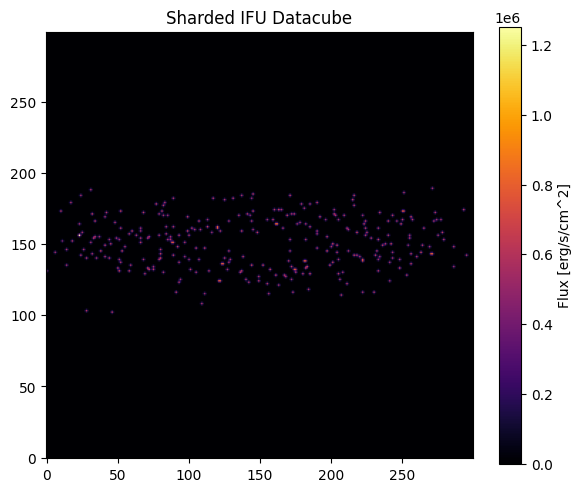

In [ ]:
#NBVAL_SKIP
import numpy as np
# get the spectra of the visible wavelengths from the ifu cube
#visible_spectra = rubixdata.stars.datacube[ :, :, visible_indices[0]]
#visible_spectra = rubixdata[ :, :, visible_indices[0]]
sharded_visible_spectra = rubixdata[ :, :, visible_indices[0]]
#visible_spectra.shape

#image = jnp.sum(visible_spectra, axis=2)
sharded_image = jnp.sum(sharded_visible_spectra, axis=2)
img32 = np.array(sharded_image, dtype=np.float32)

# Plot side by side
plt.figure(figsize=(6, 5))

# Original IFU datacube image
#im0 = axes[0].imshow(image, origin="lower", cmap="inferno")
#axes[0].set_title("Original IFU Datacube")
#fig.colorbar(im0, ax=axes[0])

# Sharded IFU datacube image
plt.imshow(img32, origin="lower", cmap="inferno")
plt.title("Sharded IFU Datacube")
plt.colorbar(label="Flux [erg/s/cm^2]")

plt.tight_layout()
plt.show()

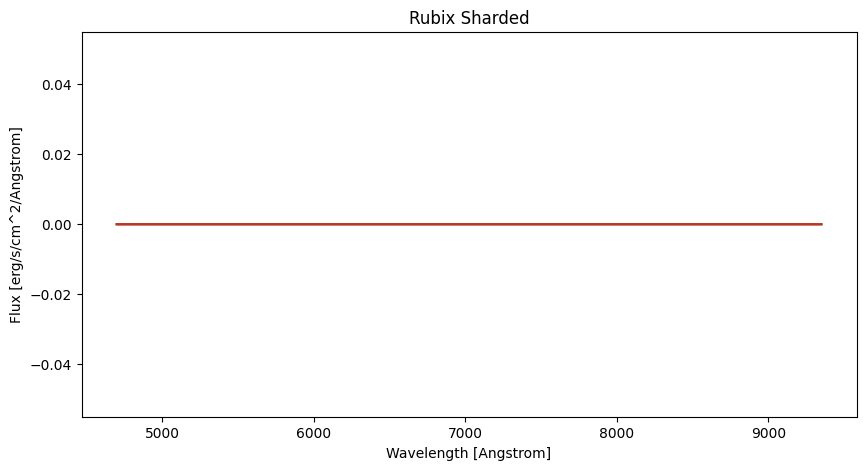

In [ ]:
#NBVAL_SKIP
wave = pipe.telescope.wave_seq

#spectra = rubixdata#.stars.datacube # Spectra of all stars
spectra_sharded = rubixdata # Spectra of all stars
#print(spectra.shape)

plt.figure(figsize=(10, 5))
#plt.subplot(1, 2, 1)
#plt.title("Rubix")
#plt.xlabel("Wavelength [Angstrom]")
#plt.ylabel("Flux [erg/s/cm^2/Angstrom]")
#plt.plot(wave, spectra[12,12,:])
#plt.plot(wave, spectra[8,12,:])

#plt.subplot(1, 2, 2)
plt.title("Rubix Sharded")
plt.xlabel("Wavelength [Angstrom]")
plt.ylabel("Flux [erg/s/cm^2/Angstrom]")
plt.plot(wave, spectra_sharded[21,15,:])
plt.plot(wave, spectra_sharded[15,21,:])
plt.plot(wave, spectra_sharded[13,4,:])
plt.plot(wave, spectra_sharded[4,13,:])

plt.show()

## DONE!

Congratulations, you have sucessfully run the RUBIX pipeline to create your own mock-observed IFU datacube! Now enjoy playing around with the RUBIX pipeline and enjoy doing amazing science with RUBIX :)